# **Лабораторная работа. Задача классификации изображений на два класса.**
# **Выполнили:** Патина Кристина, Рагузова Татьяна 16ПМИ

Мы решили взять задачу определения 2 классов - есть кошка или есть собака.

Мы использовали изображения с соревнования по машинному обучению под названием "Dogs vs Cats" на kaggle.com. Набор для обучения включает в себя 25000 изображений: 12500 кошек и 12500 собак. А для теста мы взяли по 100 картинок каждого класса.

In [ ]:
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from keras.utils import np_utils
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

Instructions for updating:
non-resource variables are not supported in the long term


# Использование сетей, предобученных на ImageNet

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.metrics import *
from keras.callbacks import *
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/




# **1.   InceptionV3**



## Чтение данных и препроцессинг изображений

Каждое изображение из датасета будем масштабировать к размеру 299 x 299 px.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'drive/My Drive/train',
    target_size=(299,299),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    'drive/My Drive/test',
    target_size=(299,299),
    batch_size=32,
    class_mode='binary')

Found 25000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Labels:

In [ ]:
test_generator.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

Примеры изображений из датасета.

0.0


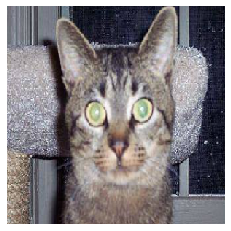

0.0


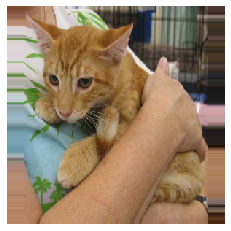

1.0


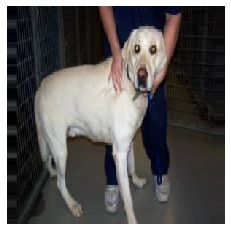

In [ ]:
images,labels = train_generator.next()
for i in range(3):
    plt.imshow(images[i])
    plt.axis('off')
    print(labels[i])
    plt.show()

## Обучение модели

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)
batch_size = 32
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer --  we have 2 classes
predictions = Dense(1,activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator)//batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)//batch_size
    )
model.save_weights('first_try.h5')

Epoch 1/10
24/24 [==============================] - 353s 15s/step - loss: 0.6549 - acc: 0.6185 - val_loss: 0.4979 - val_acc: 0.7650
Epoch 2/10
24/24 [==============================] - 299s 12s/step - loss: 0.5637 - acc: 0.7383 - val_loss: 0.4072 - val_acc: 0.8650
Epoch 3/10
24/24 [==============================] - 296s 12s/step - loss: 0.5648 - acc: 0.7174 - val_loss: 0.2892 - val_acc: 0.9600
Epoch 4/10
24/24 [==============================] - 295s 12s/step - loss: 0.4823 - acc: 0.7891 - val_loss: 0.2428 - val_acc: 0.9500
Epoch 5/10
24/24 [==============================] - 295s 12s/step - loss: 0.4815 - acc: 0.7747 - val_loss: 0.1959 - val_acc: 0.9650
Epoch 6/10
24/24 [==============================] - 293s 12s/step - loss: 0.4510 - acc: 0.7930 - val_loss: 0.1890 - val_acc: 0.9550
Epoch 7/10
24/24 [==============================] - 287s 12s/step - loss: 0.4447 - acc: 0.8060 - val_loss: 0.1808 - val_acc: 0.9550
Epoch 8/10
24/24 [==============================] - 285s 12s/step - loss: 0.

Точность 95%

### Скорость работы модели: 2976 сек ~ 50 мин
### Вес модели: 96 112 376 байт ~ 96 Мбайт

## Предсказание на тестовой выборке

### Проиллюстрируем работу модели

Посмотрим, сколько правильных и неправильных ответов дала модель для каждого класса.

In [ ]:
imgs,labels=test_generator.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
rounded_pred=np.asarray([np.round(i) for i in predictions])

In [ ]:
pd.value_counts(labels)

0.0    16
1.0    16
dtype: int64

In [ ]:
pred = []
for i in rounded_pred:
    pred.append(i[0])
pred = np.asarray(pred)

In [ ]:
pd.crosstab(labels,pred)

col_0,0.0,1.0
row_0,,
0.0,16,0
1.0,7,9


Для модели было загружено 32 случайных изображения: 16 изображений кошек и 16 собак. Модель правильно распознала всех кошек. Из 16 собак правильно были распознаны 9. Общая точность модели на этой узкой выборке составила 72%.

### Посмотрим, какие фотографии были распознаны неправильно

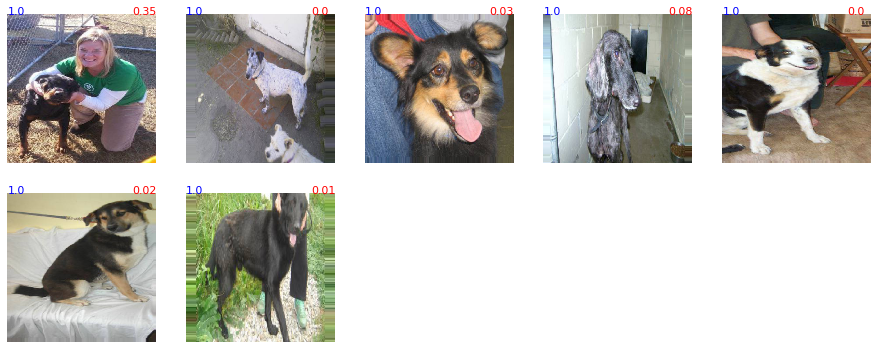

In [ ]:
from scipy import ndimage

wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]!=im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong[:32]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(250, 0, np.round(val[3][0], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(ndimage.rotate(im, 270))

Синие числа-истинный класс изображений. Красные числа- предсказанные моделью (если красное число меньше 0.5, модель считает, что на фото кот, если больше 0.5, то собака).

## *Предсказание на наших собственных данных*
В этот датасет входят всего 12 фотографий. 7 кошек и 5 собак. Здесь есть наши питомцы, домашние животные наших знакомых и фото собак и кошек из Instagram, и одна забавная картинка кота.

In [ ]:
test2_generator = test_datagen.flow_from_directory(
    'drive/My Drive/our_pictures',
    target_size=(299,299),
    batch_size=32,
    class_mode='binary')

Found 12 images belonging to 2 classes.


In [ ]:
imgs,labels=test2_generator.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
rounded_pred=np.asarray([np.round(i) for i in predictions])

In [ ]:
pd.value_counts(labels)

0.0    7
1.0    5
dtype: int64

Как и говорилось выше, 7 кошек и 5 собак.

In [ ]:
pred = []
for i in rounded_pred:
    pred.append(i[0])
pred = np.asarray(pred)
pd.crosstab(labels,pred)

col_0,0.0,1.0
row_0,,
0.0,7,0
1.0,2,3


Неправильно определились 2 собаки. Посмотрим на их картинки и полученные метки.

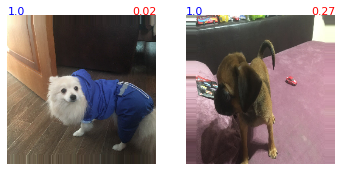

In [ ]:
from scipy import ndimage

wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]!=im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(250, 0, np.round(val[3][0], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(ndimage.rotate(im, 270))

Посмотрим на изображения, которые идентифицировались правильно.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


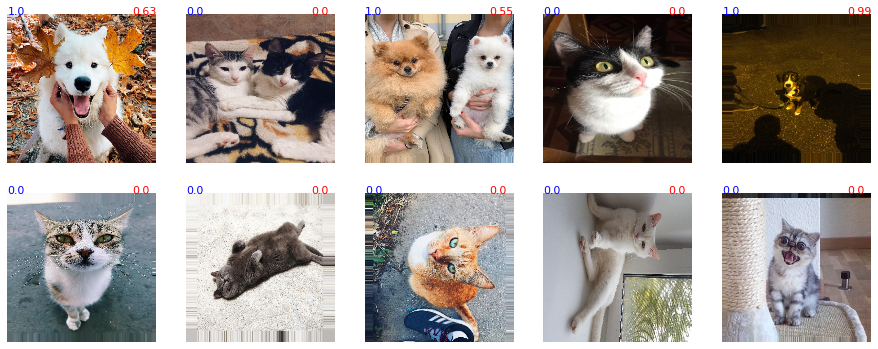

In [ ]:
right=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]==im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(right):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(250, 0, np.round(val[3][0], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(ndimage.rotate(im, 270))

# **2. VGG16**

In [ ]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


## Чтение данных и препроцессинг изображений

Каждое изображение из датасета будем масштабировать к размеру 224 x 224 px. Также теперь в обучающей выборке 2000 картинок. 1000 собак и 1000 кошек.

In [ ]:
train_generator2 = train_datagen.flow_from_directory(
    'drive/My Drive/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

test_generator2 = test_datagen.flow_from_directory(
    'drive/My Drive/test',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

test2_generator2 = test_datagen.flow_from_directory(
    'drive/My Drive/our_pictures',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


## Обучение модели

In [ ]:
# create the base pre-trained model
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
batch_size2 = 32

x2 = base_model2.output
x2 = Flatten()(x2)
x2 = Dense(256, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
# and a logistic layer --  we have 2 classes
predictions2 = Dense(1, activation='softmax')(x2)

# this is the model we will train
model2 = Model(inputs=base_model2.input, outputs=predictions2)

# first: train only the top layers (which were randomly initialized)
for layer in base_model2.layers:
    layer.trainable = False

model2.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# train the model on the new data for a few epochs
model2.fit_generator(
    train_generator2,
    steps_per_epoch=800//batch_size2,
    epochs=10,
    validation_data=test_generator2,
    validation_steps=500//batch_size2
    )
model2.save_weights('second_try.h5')

Epoch 1/10
25/25 [==============================] - 188s 8s/step - loss: 8.1306 - acc: 0.4900 - val_loss: 8.0081 - val_acc: 0.4977
Epoch 2/10
25/25 [==============================] - 174s 7s/step - loss: 7.9129 - acc: 0.5037 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/10
25/25 [==============================] - 117s 5s/step - loss: 7.8915 - acc: 0.5050 - val_loss: 8.4140 - val_acc: 0.4722
Epoch 4/10
25/25 [==============================] - 13s 535ms/step - loss: 7.8516 - acc: 0.5075 - val_loss: 7.5283 - val_acc: 0.5278
Epoch 5/10
25/25 [==============================] - 11s 436ms/step - loss: 8.0310 - acc: 0.4962 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/10
25/25 [==============================] - 17s 693ms/step - loss: 8.2701 - acc: 0.4812 - val_loss: 7.8974 - val_acc: 0.5046
Epoch 7/10
25/25 [==============================] - 13s 529ms/step - loss: 8.1306 - acc: 0.4900 - val_loss: 8.0103 - val_acc: 0.4975
Epoch 8/10
25/25 [==============================] - 12s 497ms/step - loss: 

### **Оценим точность модели**

In [ ]:
model2.evaluate_generator(test_generator2, val_samples=32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras_pre..., steps=32)`
  """Entry point for launching an IPython kernel.


[7.885296369421071, 0.5053879310344828]

Точность 50%. Очень маленькая.

### Скорость работы модели: 570 сек ~ 10 мин
### Вес модели: 553 467 096 байт ~ 554 Мбайт

## Предсказание на тестовой выборке

### Проиллюстрируем работу модели

Посмотрим, сколько правильных и неправильных ответов дала эта модель для каждого класса.

In [ ]:
imgs,labels=test_generator2.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model2.predict(imgs)
rounded_pred=np.asarray([np.round(i) for i in predictions])

In [ ]:
pd.value_counts(labels)

1.0    17
0.0    15
dtype: int64

In [ ]:
pred = []
for i in rounded_pred:
    pred.append(i[0])
pred = np.asarray(pred)

In [ ]:
pd.crosstab(labels,pred)

col_0,1.0
row_0,
0.0,15
1.0,17


Для модели было загружено 32 случайных изображения: 15 изображений кошек и 17 собак. Модель правильно распознала всех собак и не распознала ни одной кошки. Общая точность модели на этой узкой выборке составила 53%.

### Посмотрим, какие фотографии были распознаны неправильно

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


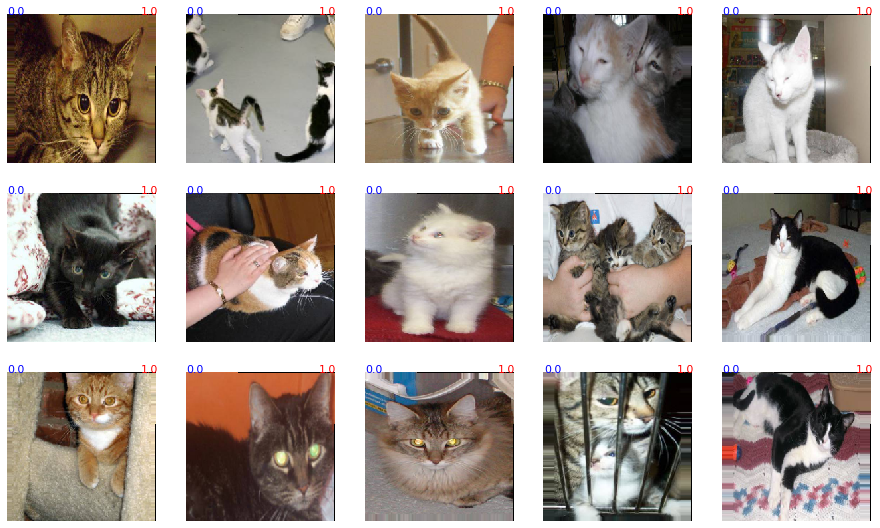

In [ ]:
from scipy import ndimage

wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]!=im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong[:32]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(200, 0, np.round(val[3][0], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(ndimage.rotate(im, 270))

## *Предсказание на наших собственных данных*

In [ ]:
imgs,labels=test2_generator2.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model2.predict(imgs)
rounded_pred=np.asarray([np.round(i) for i in predictions])

In [ ]:
pred = []
for i in rounded_pred:
    pred.append(i[0])
pred = np.asarray(pred)
pd.crosstab(labels,pred)

col_0,1.0
row_0,
0.0,7
1.0,5


Опять же все кошки определились неправильно. Посмотрим на их изображения.

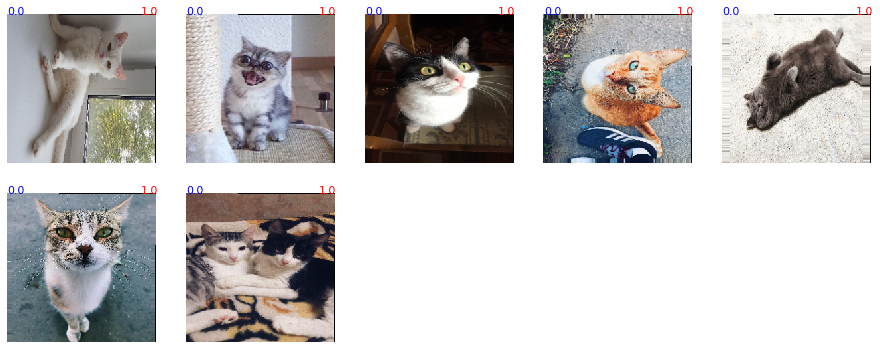

In [ ]:
from scipy import ndimage

wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]!=im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(200, 0, np.round(val[3][0], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(ndimage.rotate(im, 270))

Неудачная архитектура получилась.

# **Выводы**

Интересное наблюдение - в первой модели неправильно определились собаки, а во второй кошки. Точность предсказаний второй модели намного меньше, чем у первой, время работы также быстрее у второй, отчасти это из-за размера обучающей выборки. А если сравнить модели по весу, то вторая весит больше. 

Из высказываний выше, следует, что первая модель получилась более удачной, по нашему мнению.